In [1]:
import pandas as pd
import numpy as np
from IPython.display import HTML

In [2]:
dir_ = '../../output/stage_2_predictions/Keck_Pria_AS_Retest'
rank_df = pd.read_csv('{}/complete_rank.csv'.format(dir_))

# Show Venn Diagram

In [3]:
import pyupset as pyu
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)
%matplotlib inline


def filter_model_name(model_name):
    model_name = model_name.replace('SingleClassification', 'STNN-C')
    model_name = model_name.replace('SingleRegression', 'STNN-R')
    model_name = model_name.replace('MultiClassification', 'MTNN-C')
    model_name = model_name.replace('RandomForest', 'RF')
    model_name = model_name.replace('ConsensusDocking', 'CD')
    model_name = model_name.replace('Docking', 'Dock')
    return model_name

In [4]:
selected_names = ['Baseline', 'ConsensusDocking_efr1_opt', 'IRV_d',
                  'RandomForest_h', 'SingleClassification_a', 'SingleRegression_b', 'MultiClassification_b',
                  'LSTM_b']
plot_dict = {}

for model_name in selected_names:
    positive_rank = rank_df[rank_df['label']>0][model_name]
    positive_rank = positive_rank.where(positive_rank<250)
    positive_rank = positive_rank.dropna()
    filtered_index = positive_rank.keys()
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


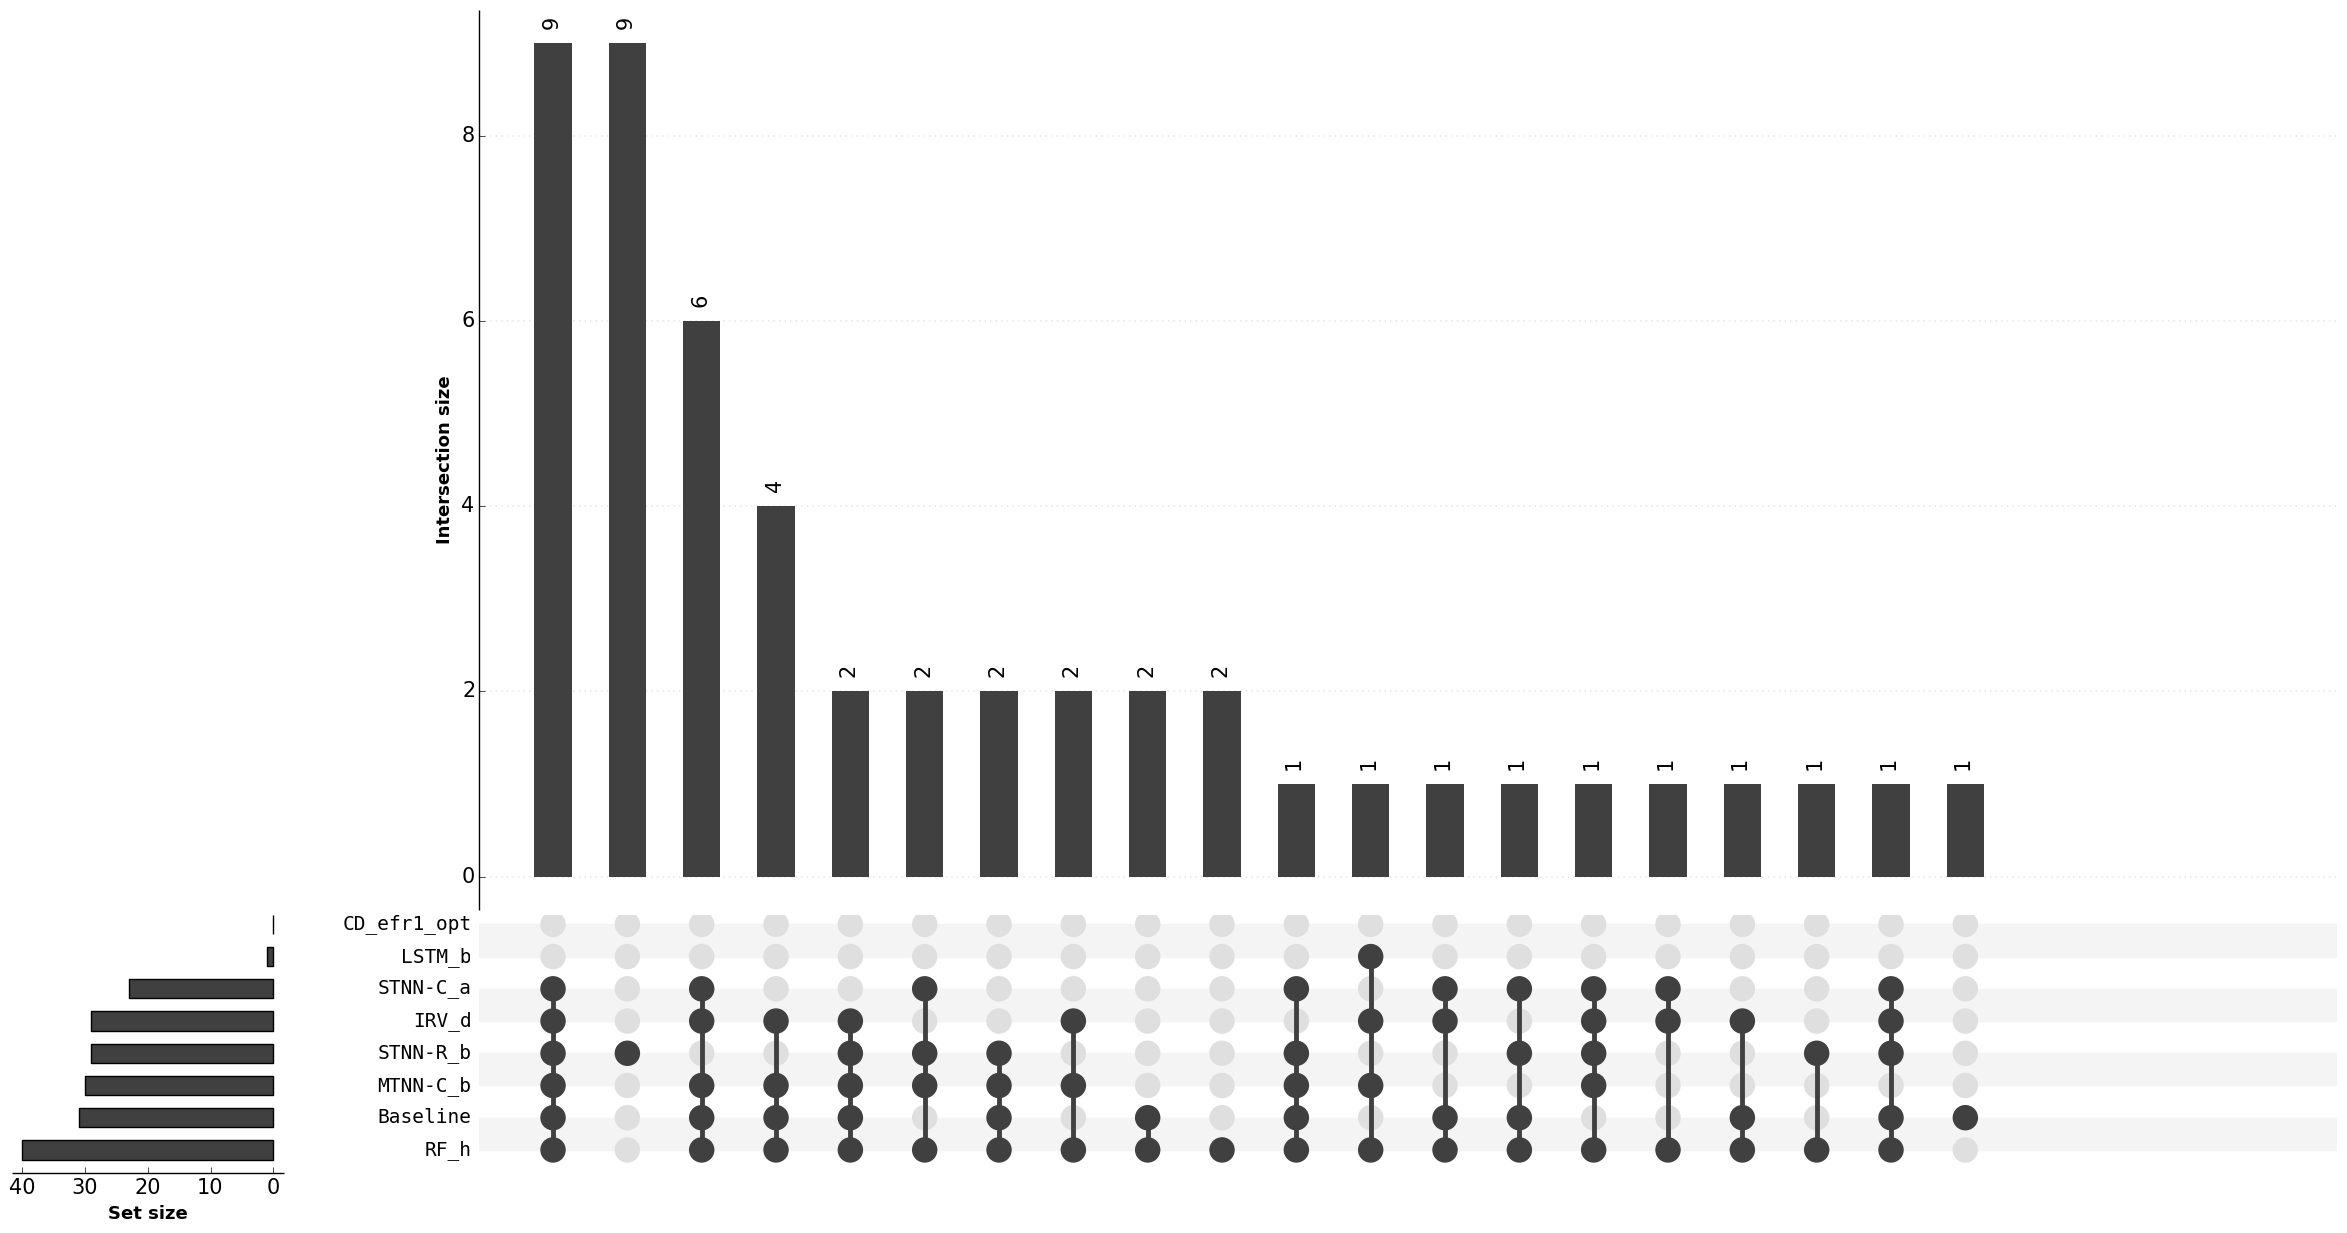

In [5]:
matplotlib.rcParams.update({'font.size': 15})
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 50))
# fig[0]['figure'].savefig('./plottings/prospective_screening_venn/venn_diagram', bbox_inches='tight')

# Show Venn Diagram based on Similarity

In [6]:
dataframe = pd.read_excel('../../output/stage_2_predictions/Keck_LC4_export.xlsx')

molecule_name_list = dataframe['Molecule Name'].tolist()
supplier_id = dataframe['Supplier ID'].tolist()
failed_id = ['F0401-0050', 'F2964-1411', 'F2964-1523']
inhibits = dataframe[
    'PriA-SSB AS, normalized for plate and edge effects, correct plate map: % inhibition Alpha, normalized (%)'].tolist()
neo_dataframe = pd.read_csv('../../output/stage_2_predictions/pria_lc4_retest_may18.csv')
failed_molecule_names = neo_dataframe[neo_dataframe['Active'] == 0]['Row Labels'].tolist()
failed_molecule_names += ['SMSSF-0044356', 'SMSSF-0030688']
    
positive_enumerate = filter(lambda x: x[1] >= 35 and supplier_id[x[0]] not in failed_id and molecule_name_list[x[0]] not in failed_molecule_names, enumerate(inhibits))
positive_idx = map(lambda x: x[0], positive_enumerate)

In [7]:
model_mapping_to_hits = []
baseline_active_set = set()
model_mapping_to_unique_hits = []
model_mapping_to_clustering = {}
clustering_df = pd.read_excel('{}/clustering/lc4_clusters.xlsx'.format(dir_))
clustering_names = clustering_df.columns[2:].tolist()
merged_clustering_df = pd.merge(rank_df, clustering_df, left_on=['molecule id'], right_on='Batch')

for clustering_name in clustering_names:
    model_mapping_to_clustering[clustering_name, model_name] = []

for (idx, model_name) in enumerate(selected_names):    
    order = rank_df[model_name].loc[positive_idx]
        
    hits_id = map(lambda x: x[0], filter(lambda x: 0<=x[1] and x[1] <=250, enumerate(order)))
    if model_name == 'Baseline':
        baseline_active_set = set(hits_id)
    current_active_set = set(hits_id)
    unique_active_set = current_active_set - baseline_active_set
    model_mapping_to_unique_hits.append(len(unique_active_set))
            
    hits = len(hits_id)
    model_mapping_to_hits.append(len(hits_id))
    
    for clustering_name in clustering_names:
        clustering_ids = set(merged_clustering_df[clustering_name].loc[hits_id].tolist())
        clustering_num = len(clustering_ids)
        model_mapping_to_clustering[clustering_name, model_name] = list(clustering_ids)

## Show Venn Diagram based on SIM

In [8]:
plot_dict = {}
clustering_name = 'SIM_Cluster'

for model_name in selected_names:
    filtered_index = model_mapping_to_clustering[clustering_name, model_name]
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

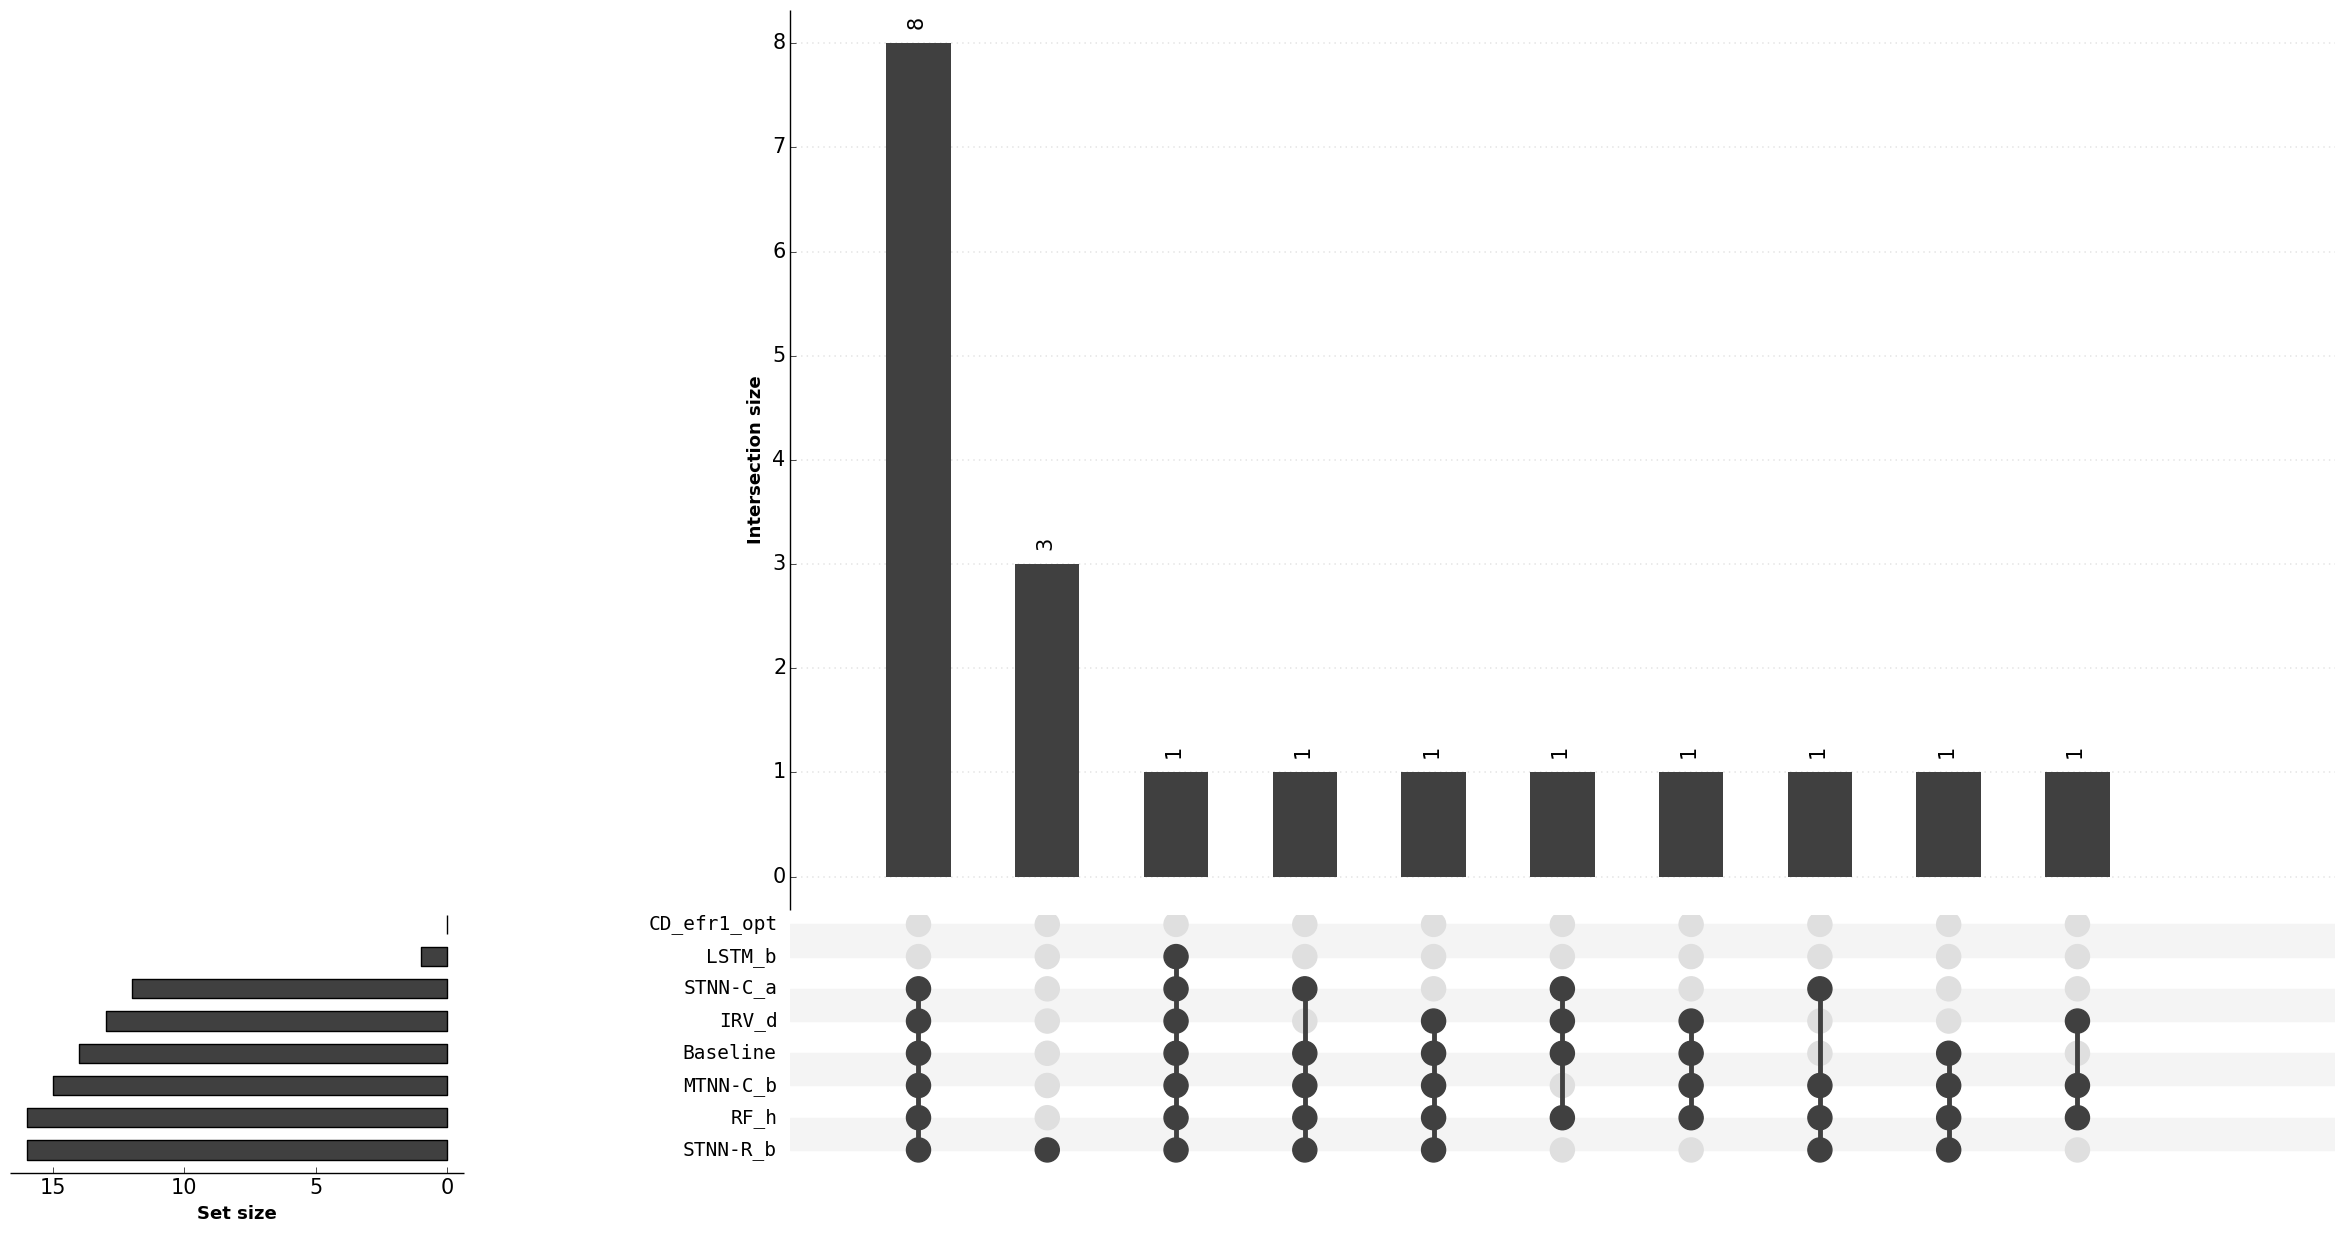

In [9]:
matplotlib.rcParams.update({'font.size': 15})
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 50))
fig[0]['figure'].savefig('./plottings/prospective_screening_venn/venn_diagram_SIM', bbox_inches='tight')

In [10]:
plot_dict = {}
clustering_name = 'MCS_Cluster'

for model_name in selected_names:
    filtered_index = model_mapping_to_clustering[clustering_name, model_name]
    filtered_df = pd.DataFrame(data=filtered_index, columns=['Items'])
    plot_dict[filter_model_name(model_name)] = filtered_df

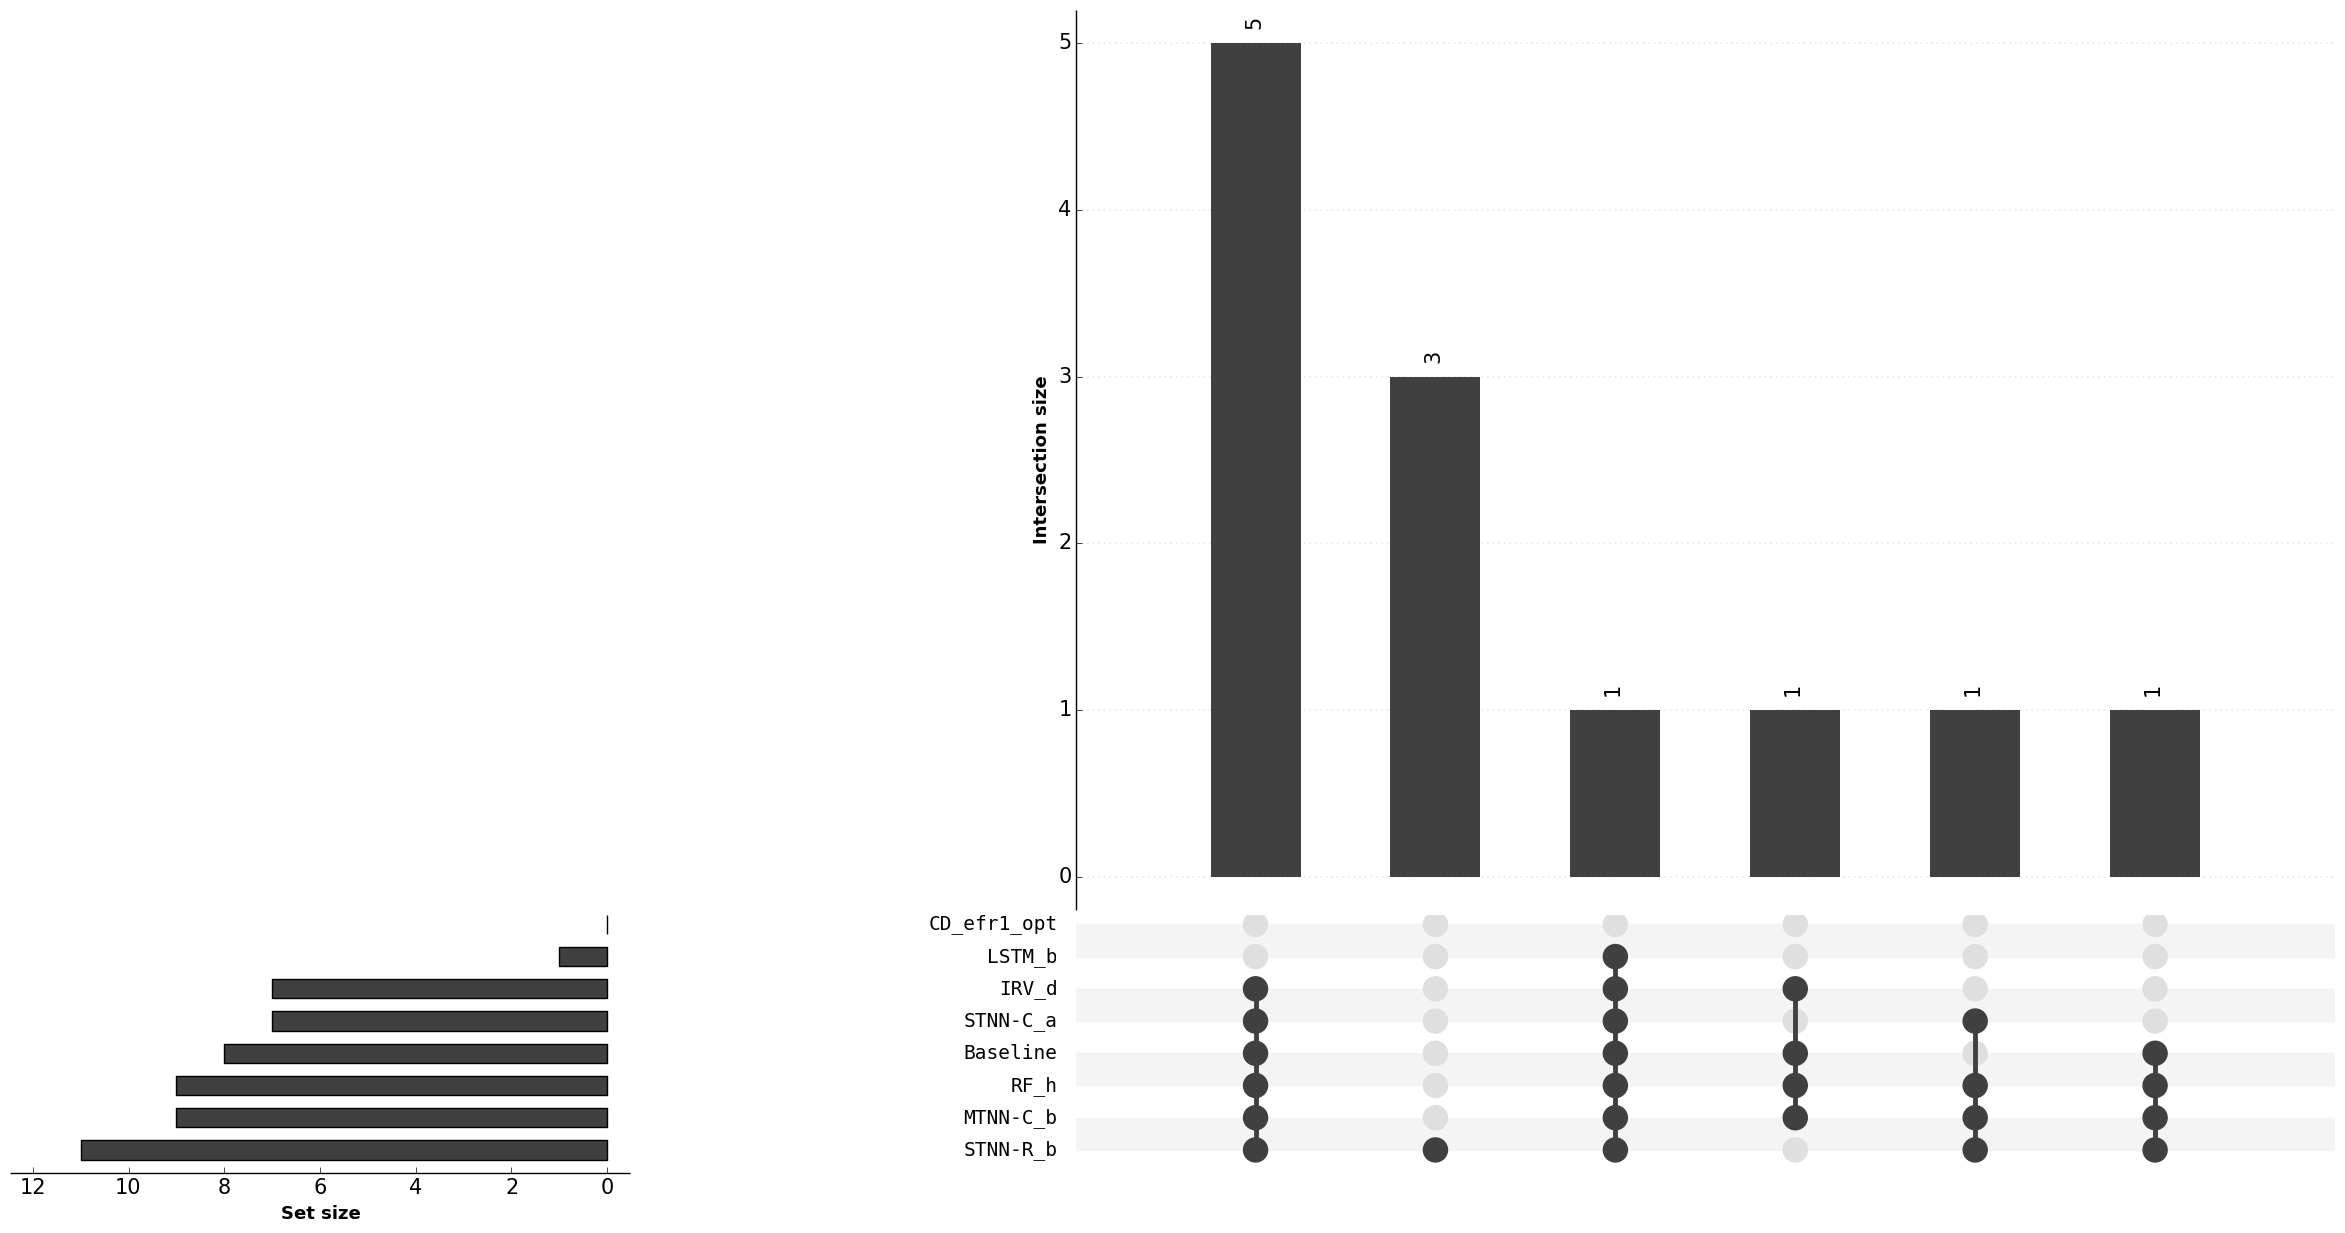

In [11]:
matplotlib.rcParams.update({'font.size': 15})
fig = pyu.plot(plot_dict, inters_size_bounds=(1, 50))
fig[0]['figure'].savefig('./plottings/prospective_screening_venn/venn_diagram_MCS', bbox_inches='tight')